# Double-Bracket Iteration Strategy: magnetic field (onsite Z)
This notebook shows the diagonalization process of DBI using the magnetic field strategy, which varies the diagonal operator $D$ by gradient descent. To find the gradient with respect to $D$, parameterization of $D$ is required. For the purpose of this notebook, we represent it by onsite Pauli-Z operators, i.e.

$$ D = \sum \alpha_i Z_i $$

Note that it is also possible to have higher-order terms, such as $ D = \sum \alpha_i Z_i + \sum \beta_{i,j}Z_iZ_j+...$

The gradients are calculated under the premise that the diagonalization gain curve can be fitted by a polynomial, and that the iteration step duration is taken at the first dip of the curve.

In [1]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from qibo import hamiltonians, set_backend
from qibo.quantum_info import random_hermitian
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketScheduling, DoubleBracketIteration
from qibo.models.dbi.utils import *

## Test on random Hamiltonian

In [2]:
# backend
set_backend("qibojit", "numba")
# initialize dbi object
nqubits = 5
h0 = random_hermitian(2**nqubits, seed=2)
dbi = DoubleBracketIteration(Hamiltonian(nqubits=nqubits, matrix=h0))
print("Initial off diagonal norm", dbi.off_diagonal_norm)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[Qibo 0.2.5|INFO|2024-02-22 08:22:59]: Using qibojit (numba) backend on /CPU:0


Initial off diagonal norm 31.576176740060667


In [3]:
# generate the onsite Z operators
onsite_Z_ops = generate_onsite_Z_ops(nqubits)
d_coef = onsite_Z_decomposition(dbi.h.matrix, onsite_Z_ops)
d = sum([d_coef[i] * onsite_Z_ops[i] for i in range(nqubits)])
grad, s = gradient_onsite_Z(dbi,d,3, onsite_Z_ops)
print('The initial D coefficients:', d_coef)
print('Gradient:', grad)
print('s:', s)

[Qibo 0.2.5|WARNING|2024-02-22 08:22:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.5|WARNING|2024-02-22 08:22:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.5|WARNING|2024-02-22 08:22:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.5|WARNING|2024-02-22 08:22:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.5|WARNING|2024-02-22 08:22:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


The initial D coefficients: [(-0.2980910136757636+0j), (-0.17678355790937256+0j), (0.294550421681131+0j), (-0.2301056409534723+0j), (-0.07297191764284382+0j)]
Gradient: [ 482.57311611  272.8003344  -526.64628147  420.97083752   47.09691378]
s: 0.06953854599881942


/Users/pethidine/anaconda3/envs/DBF_qibo/lib/python3.11/site-packages/qibo/models/dbi/utils.py:228: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[i] = s**3/3*da + s**2/2*db + 2*s*dc + s**2*ds*a + s*ds*b+ 2*ds*c


In [4]:
iters = 30
off_diagonal_norm_tot = [dbi.off_diagonal_norm]
num_iters = []
s_step = [0]
for i in range(iters):
    s, d_coef, d, off_diagonal_norm_history = gradient_descent_onsite_Z(dbi, d_coef, d, onsite_Z_ops=onsite_Z_ops, max_evals=100)
    off_diagonal_norm_tot.append(off_diagonal_norm_history[-1])
    num_iters.append(len(off_diagonal_norm_history))
    s_step.append(s)

/Users/pethidine/anaconda3/envs/DBF_qibo/lib/python3.11/site-packages/qibo/models/dbi/double_bracket.py:106: RuntimeWarning: overflow encountered in matmul
  return a @ b - b @ a
/Users/pethidine/anaconda3/envs/DBF_qibo/lib/python3.11/site-packages/qibo/models/dbi/double_bracket.py:106: RuntimeWarning: invalid value encountered in matmul
  return a @ b - b @ a


Text(0, 0.5, '$|| \\sigma(e^{sW}He^{-sW}) || $')

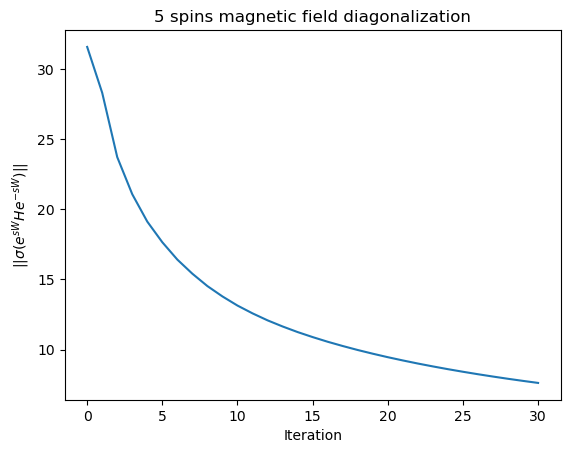

In [5]:
plt.title(str(nqubits) + ' spins magnetic field diagonalization')
plt.plot(off_diagonal_norm_tot)
plt.xlabel('Iteration')
plt.ylabel(r'$|| \sigma(e^{sW}He^{-sW}) || $')

In [6]:
h_input = SymbolicHamiltonian( symbols.Z(0)+symbols.X(0) + symbols.Z(0) * symbols.X(1) + symbols.Y(2) + symbols.Y(1) * symbols.Y(2), nqubits = 3 )

In [10]:
dbi = DoubleBracketIteration(deepcopy(h_input.dense))

[Qibo 0.2.5|WARNING|2024-02-22 08:38:54]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [11]:
dbi(step=0.1)